## Table Of Contents
<div class="alert alert-info">
    <b> </b>

1. [Introduction](#h1)

2. [Preparation](#h2)

3. [Data Preprocessing](#h3)  

4. [Fine-tuning the LLama 3.2 Model](#h4)

5. [Model Evaluation, FT](#h4.1)

6. [Creating the Classification Model](#h5)

7. [Model Evaluation, NNC](#h5.1)

8. [Integrating Patient Data & EMMA](#h6)

9. [Conclussions](#h7)

10. [References](#h8)

# 1. Creating EMMA, an introduction

Dementia is a progressive neurological condition that affects millions of people worldwide, causing memory loss, cognitive decline, and difficulty with communication. For individuals living with dementia, maintaining meaningful interactions and feeling understood can significantly enhance their quality of life (NPR, 2017; McMahon et al., 2023). Technology, particularly advancements in artificial intelligence (AI), offers innovative ways to support these individuals and their caregivers.

In this project, an empathetic large language model (LLM) has been developed with the intention to assist individuals suffering from dementia. The lightweight [LLaMA 3.2](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2#-llama-3.2-lightweight-models-(1b/3b)-) model with 1B parameters was trained on an empathetic dialogues dataset to enhance its ability to respond compassionately. Following training, responses were generated from both the fine-tuned model and the base LLaMA 3 model to a set of 1,000 dementia-related questions. To evaluate the trained model, a separate neural network classifier was trained to distinguish between the responses from 1000 questions between the base model and the trained model. If the classifier could reliably differentiate the responses, it would have been a good indication that the fine-tuned model had effectively altered their responses based on the dataset. In case the neural network classifier showed reliable change, the next step would be to judge the responses with human assesment to decide if they are not only to be considered different responses, but improved responses for its purpose (showcasing more empathy). 

The second aspect of this project is a custom retrieval mechanism, where a database stores sample patient information. The system retrieves relevant details by querying the database with the patient ID for each input prompt. This ensures that the model provides accurate, context-aware responses tailored to the individual. 

### Research Insights

To asses the relevance of this project and to gain knowledge regarding the  patient database information a meeting was had with Johanneke Pulles, [LinkedIn](https://www.linkedin.com/in/johanneke-pulles-86a99b12/?originalSubdomain=nl). Pulles has 24 years of experience at Cordaan, a nursing home where she is reguarly invloved in dementia care. This meeting generated valuable insights, to be further discussed in chapter 7: [Integrating Patient Data & EMMA](#h7).

*Throughout this notebook we have used, altered and copied code from the tutorials and videos that we reference at the end of this notebook.*

# 2. Preparation

In this section, we will load the necessary dependencies for the project. These dependencies will enable us to work with the model and perform tasks such as data preprocessing, and model fine-tuning to provide personalized, dementia-focused conversations. Below we briefly explain key parts of this process:

1. **Importing Libraries**: We import necessary libraries such as `transformers`, `peft` (Parameter-Efficient Fine-Tuning), and `trl` (transformers for Reinforcement Learning), which support model training and evaluation.
2. **Model Preparation**: 
   - `AutoModelForCausalLM` and `AutoTokenizer` handle loading the pre-trained model and tokenizer.
   - `BitsAndBytesConfig` allows efficient training using quantization.
   - `prepare_model_for_kbit_training` prepares the model for low-precision fine-tuning.
3. **Dataset Loading**: `datasets.load_dataset` loads the data we'll use for training.
4. **Fine-Tuning**: 
   - `LoraConfig` and `get_peft_model` enable efficient fine-tuning using LoRA (Low-Rank Adaptation).
   - `SFTTrainer` simplifies the supervised fine-tuning process.
5. **Pipeline Setup**: The `pipeline` creates an inference pipeline for generating predictions after training.
6. **Logging and Monitoring**: `wandb` (Weights & Biases) allows us to track the performance metrics of our trained models.
7. **Authentication with Hugging Face Hub**: We use `huggingface_hub` to authenticate and securely access the Hugging Face platform using a token that we generated on this platform. This allows us save our fine-tuned model on their platform. 

In [1]:
%%capture
%pip install -U transformers 
%pip install -U datasets 
%pip install -U accelerate 
%pip install -U peft 
%pip install -U trl 
%pip install -U bitsandbytes 
%pip install -U wandb
%pip install scikit-learn
%pip install tensorflow

import numpy as np 
import pandas as pd 
import os
import kagglehub
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import torch, wandb
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig, setup_chat_format

In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACE_KEY")

login(token = hf_token)

### Set Up for Fine Tuning
We set the variables for our base model, Meta LLama 3, and our trained model:

In [4]:
base_model = "/kaggle/input/llama-3.2/transformers/1b-instruct/1"
new_model = "llama-3-chat-empathy-25000-3e"

Then, we set the data type and attention implementation: This helps reduce memory usage and speeds up computations, especially on GPUs. "Eager" mode  means that operations are executed immediately as they are called, which can be useful for debugging and development:

In [5]:
torch_dtype = torch.float16
attn_implementation = "eager"

The next step configures **QLoRA (Quantized Low-Rank Adaptation)** It optimizes the model for faster and memory-efficient processing by:

1. **4-bit Quantization**: Reduces the precision of model weights to 4 bits, minimizing memory usage and speeding up computations.
2. **NF4 Quantization Type**: Uses the NormalFloat4 (NF4) format, which improves numerical stability during training.
3. **Compute Data Type**: Specifies the precision for internal computations, we specifizied this to float16 in the previous step.
4. **Double Quantization**: Adds an extra layer of quantization for further memory savings while maintaining performance.

This allows the base model to run on limited hardware, like our kaggle environment without significant performance trade-offs..

In [6]:
# QLoRA config (speeds up processing)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)


Here we load the base model and it's tokenizer, and set up the tokenizer for conversational AI tasks.

In [7]:
# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.pad_token = tokenizer.eos_token

Fine-tuning the full model will take a significant amount of time, hence, to improve the training time, **an adapter layer with a few parameters will be attached using LoRA configuration**, making the entire process faster and more memory-efficient.

In [8]:
# LoRA config
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)

# Applying LoRA to the Model:
model = get_peft_model(model, peft_config)

To assess whether the model was loaded correctly, it is used to generate a response to a "I am hurt" input prompt.

In [9]:
model_id = "/kaggle/input/llama-3.2/transformers/1b-instruct/1"
pipe = pipeline(
    "text-generation",
    model=model_id,
    device_map="auto",
)
messages = [
    {"role": "system", "content": "You are an AI assistant specialized in dementia care. Respond patiently, clearly, and empathetically to questions. Reassure and guide the user gently while avoiding complex language."},
    {"role": "user", "content": "I am hurt"},
]
outputs = pipe(
    messages,
    max_new_tokens=128,
    do_sample=True
)
print(outputs[0]["generated_text"][-1])

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'role': 'assistant', 'content': "It can be very painful and overwhelming when we're feeling hurt. I'm here to listen and support you. Would you like to talk about what's making you feel hurt? Sometimes sharing what's on your mind can help us process and feel better.\n\nRemember, you're not alone, and I'm here to listen and support you. I'll do my best to create a safe and non-judgmental space for you to express yourself."}


# 3. Data Preprocessing

The [empathetic chat dataset](https://www.kaggle.com/datasets/atharvjairath/empathetic-dialogues-facebook-ai) was loaded, shuffled, and reduced to 25,000 rows to optimize training time and computational efficiency. 

The chat format was then restructured into a conversational style by combining questions and responses into a single "text" column for consistency and ease of use.

Finally, the dataset was divided into training and validation sets to facilitate model training and evaluation.

In [10]:
# Download latest version
path = kagglehub.dataset_download("atharvjairath/empathetic-dialogues-facebook-ai")
print("Path to dataset files:", path)
dataset_name = "/kaggle/input/empathetic-dialogues-facebook-ai"

# Load dataset and take a subset for demo purposes
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.select(range(25000))
dataset = dataset.shuffle(seed=65)  #using 25000 samples to train

# Select specific columns
columns_to_keep = dataset.column_names[3:-2]  # Adjust indices for your case
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in columns_to_keep])

# View the dataset
print(dataset[:5])  # Prints the first 5 rows
print(len(dataset))

Path to dataset files: /kaggle/input/empathetic-dialogues-facebook-ai


Generating train split: 0 examples [00:00, ? examples/s]

{'empathetic_dialogues': ['Customer :unexpected is even better than expected! congrats! \nAgent :', 'Customer :I am going to a party this weekend\nAgent :', 'Customer :I went to church and everything this week. Maybe I will be blessed in my career!\nAgent :', 'Customer :oh cool buddy.. how much did you win?\nAgent :', "Customer :I failed my final exam. Now I'll lose my scholarship.\nAgent :"], 'labels': ["Yes, I'm so very happy for it!", 'Awesome!  Are you excited to go?', 'I hope that does good things for you. They say if you believe in something enough it comes true.', 'i cant disclose that ', 'Oh man, that must be a horrible feeling.']}
25000


In [11]:
# "role": "user": The user's message (from the "empathetic_dialogues" column in the dataset).
# "role": "assistant": The assistant's message (from the "labels" column in the dataset).

def format_chat_template(row):
    row_json = [{"role": "user", "content": row["empathetic_dialogues"]},
               {"role": "assistant", "content": row["labels"]}]
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

dataset = dataset.map(
    format_chat_template,
    num_proc=4,
)

# View sample of data
dataset['text'][20]

# Training and Test split
dataset = dataset.train_test_split(test_size=0.1)

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/25000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


# 4. Fine-tuning the LLaMA 3 Model

This section focuses on fine-tuning the LLaMA 3 model using the empathetic dialogues dataset to enhance its ability to engage in compassionate and understanding conversations. The training process is configured with TrainingArguments and the SFTTrainer class, incorporating parameters such as batch sizes, learning rate, and evaluation steps to ensure efficient and effective fine-tuning. By training on this specialized dataset, the model is refined to deliver more empathetic and supportive interactions, making it well-suited for dementia-focused applications.

The model is trained on 25000 rows, for 3 epochs. This took around three hours to train. A [tutorial](https://www.datacamp.com/tutorial/fine-tuning-llama-2) was used to fine-tune these hyper-parameters.

In [12]:
training_arguments = TrainingArguments(
    output_dir=new_model,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=3, #adjusted to 3 epochs
    eval_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="wandb"
)

Setting up a supervised fine-tuning (SFT) trainer, using predivined arguments from previous steps:

In [13]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

/tmp/ipykernel_23/2883752247.py:1: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

The fine-tuning process is initiated using the code provided below. For simplicity and clarity, this notebook does not execute the fine-tuning code directly. Instead, the process was conducted in a forked environment, and the fine-tuned model is imported through git clone, where the files were saved on the HuggingFace platform wich we pushed the model to after fine tuning.

In [14]:
#trainer.train()

In [15]:
!git clone https://huggingface.co/IsaHug/llama-3-chat-empathy-25000-3e

new_model = "/kaggle/working/llama-3-chat-empathy-25000-3e"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'llama-3-chat-empathy-25000-3e'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 8 (from 1)
Unpacking objects: 100% (14/14), 7.93 KiB | 1.98 MiB/s, done.


## Model Evaluation, FT

The code below finishes the Weights & Biases session, it will generate the run history and summary, providing us with performance metrics of our trained model. Because these were run in a different notebook, the table with training and validation loss is displayed through an image. We see that there is a decrease in both, indicating that the model learned during training.

In [16]:
#wandb.finish()
#model.config.use_cache = True

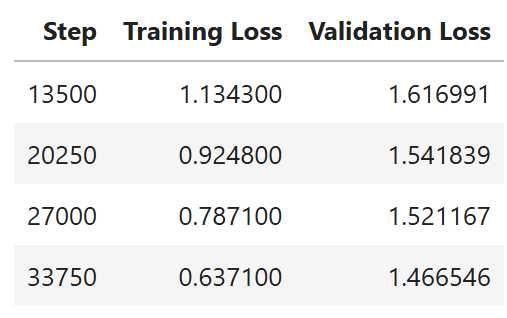

The fine-tuned model is saved and pushed to the Hugging Face Hub. The Hub API will automatically create the repository and store the adapter file. This code is commented out as well since the model was trained in a forked notebook.

In [17]:
#trainer.model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)
#trainer.model.push_to_hub(new_model, use_temp_dir=False)

('/kaggle/working/llama-3-chat-empathy-25000-3e/tokenizer_config.json',
 '/kaggle/working/llama-3-chat-empathy-25000-3e/special_tokens_map.json',
 '/kaggle/working/llama-3-chat-empathy-25000-3e/tokenizer.json')

We test our model to see if everthing is loaded correctly:

In [18]:
pipe = pipeline(
    "text-generation",
    model=new_model,
    tokenizer=tokenizer,
    device_map="auto",
)
messages = [
    {"role": "system", "content": "You are an AI assistant specialized in dementia care. Respond patiently, clearly, and empathetically to questions. Reassure and guide the user gently while avoiding complex language."},
    {"role": "user", "content": "I am hurt"},
]
outputs = pipe(
    messages,
    max_new_tokens=128,
    do_sample=True
)
print(outputs[0]["generated_text"][-1])

Device set to use cuda:0


{'role': 'assistant', 'content': "I'm so sorry to hear that you're feeling hurt. It can be really tough to feel that way, especially when we're already feeling overwhelmed. Can you tell me more about what's been going on and how you're feeling? Sometimes talking about it can help us process our emotions and feel a little better. I'm here to listen and support you."}


# 5. Creating The Classification Model

**To assess the capabilities of the fine-tuned model, a classification model is employed to differentiate between responses generated by the fine-tuned and base versions of the LLaMA 3 model.** By training the classifier on a dataset of responses to dementia-related questions, the model attempts to identify patterns that are different between the responses. This step serves as a quantitative evaluation of the fine-tuning process, providing insights into the effectiveness of the modifications in enhancing the model’s qualities.

### 5.1 Generating the questions and the responses

Both models were evaluated on dementia-related questions to generate distinct outputs. The questions have been generated by GPT4o. The actual code for generating these responses was executed in a separate notebook. For simplicity and ease of viewing, the resulting dataset will be imported here, and the code used to produce the responses is displayed below, commented out. 

In [19]:
# File path to the CSV containing dementia-related questions
#file_path = "/kaggle/input/dementia-related-questions/questions.csv"

# Read the CSV file into a DataFrame
#df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
#print(df.head())

In [20]:
#import time
# Initialize models
#model_id = "/kaggle/input/llama-3.2/transformers/1b-instruct/1"
#model = "/kaggle/working/llama-3-chat-empathy-25000-3e"

#pipe = pipeline(
#    "text-generation",
#    model=model_id,
#    device_map="auto",
#    torch_dtype="auto"
#)

#pipe_new = pipeline(
#    "text-generation",
#    model=model,
#    device_map="auto",
#    torch_dtype="auto"
#)


# Start the timer
#start_time = time.time()

# Generate responses for each question using both models
#responses = []  # To store all rows for the DataFrame
#for question in questions:
    # Prepare the prompt for both models
#    message = [
#        {"role": "system", "content": "You are an AI assistant specialized in dementia care. Respond patiently, clearly, and empathetically to questions. Reassure and guide the user gently while avoiding complex language."},
#        {"role": "user", "content": question}
#    ]
    
#    # Generate response from the first model
#    response_1 = pipe(message, max_new_tokens=128, do_sample=True)[0]["generated_text"][-1]
#    responses.append({
#        "Question": question,
#        "Response": response_1,
#        "Model": "Base_Model"
#    })
#    
#    # Generate response from the second model
#    response_2 = pipe_new(message, max_new_tokens=128, do_sample=True)[0]["generated_text"][-1]
#    responses.append({
#        "Question": question,
#        "Response": response_2,
#        "Model": "Trained_Model"
#    })
#
# Create a DataFrame
#df = pd.DataFrame(responses)

# End the timer
#end_time = time.time()

# Print DataFrame and execution time
#print(df)
#print(f"Execution time: {end_time - start_time:.4f} seconds")
#
# Save to a CSV if needed
#df.to_csv("model_responses_comparison.csv", index=False)''

### 5.2 Data Preparation

Cleaning, tokenizing and splitting the dataset into a train and test set, to make it suitable for training.

In [21]:
# File path to the CSV inside the directory
file_path = "/kaggle/input/generated-responses/model_responses_comparison (2).csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

import re

# Function to extract text within brackets
def extract_text_from_brackets(Response):
    match = re.search(r"'content': \"(.*?)\"", Response)
    return match.group(1) if match else None

# Apply the function to the Response column
df['Response'] = df['Response'].apply(extract_text_from_brackets)

print(df[:5])

         Question                                           Response  \
0     Where am I?  You are at home. You're safe and sound here. I...   
1     Where am I?  You're in a comfortable and familiar space. Yo...   
2    Who are you?  Hello! I'm an AI assistant, and I'm here to he...   
3    Who are you?  I'm an AI assistant, and I'm here to help you ...   
4  Why am I here?  It sounds like you're feeling a bit uncertain ...   

           Model  
0     Base_Model  
1  Trained_Model  
2     Base_Model  
3  Trained_Model  
4     Base_Model  


In [22]:
#tokenize and encode labels
from transformers import TFAutoModel

#combine the prompt and response so model is able to better understand context
df["combined"] = df["Question"].astype(str) + " [SEP] " + df["Response"].astype(str)

#tokenize
tokenized = tokenizer(
    list(df["combined"]),
    padding = True,
    truncation = True,
    max_length = 128,
    return_tensors = "tf"
)

#extract token ID's
X = tokenized["input_ids"]
attention_mask = tokenized["attention_mask"]

#transform labels to 0 (base model) and 1 (new model)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Model"])

In [23]:
#split into test and training, do same for attention masks
from sklearn.model_selection import train_test_split

# Convert to numpy arrays before splitting
X_numpy = X.numpy()  # Convert TensorFlow tensor to NumPy array
attention_mask_numpy = attention_mask.numpy()

#splitting using train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X_numpy,
                                                    y,
                                                    test_size = 0.2, 
                                                    random_state = 42)

attention_mask_train, attention_mask_test = train_test_split(
    attention_mask_numpy, test_size=0.2, random_state=42
)

### 5.3 Building the classifier

In this section, we define and run a neural network using TensorFlow's Keras API. Provided is a breakdown of the model:

- **Model Architecture**: 
  The model is a sequential neural network, meaning the layers are added in order from input to output. The input has shape `(128,)`.  
  - The first layer has **64 neurons** and uses the ReLU activation function to introduce non-linearity.  
  - The second layer has **32 neurons**, also using ReLU activation.  
  - The final layer is the output layer with **1 neuron** and a sigmoid activation function, which outputs a probability value for binary classification tasks, making it suitable for our 'base model' or 'trained model' task.

- **Model Compilation**: 
  - We use the **Adam optimizer**, which adapts the learning rate during training for better convergence.  
  - The **binary_crossentropy loss function** is well-suited for binary classification, as it measures the difference between predicted and actual probabilities.  
  - The **binary_accuracy metric** is added to monitor the model's performance during training, showing the proportion of correctly predicted samples.


In [24]:
import tensorflow.keras as tf_keras
from tensorflow.keras import layers

model = tf_keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(128,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# define early stopping 
from tf_keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0, # verbose to hide the output if needed
)

I0000 00:00:1734885619.257894     222 service.cc:145] XLA service 0x784718007560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734885619.257955     222 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734885620.156849     222 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Best Validation Loss: 571.3126
Best Validation Accuracy: 0.5300


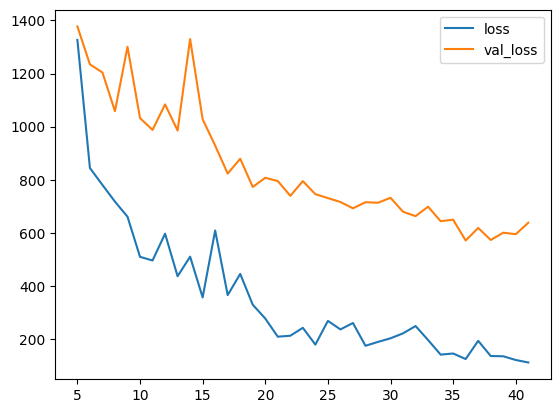

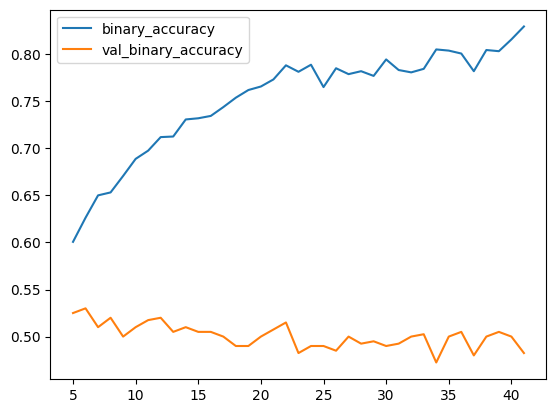

In [26]:
# plot
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

## Model Evaluation, NNC 

**The classification model achieved a correct classification rate of approximately 53%, which is only slightly better than guessing.** This result indicates that the classifier struggled to distinguish between responses generated by the fine-tuned model and those from the base LLaMA 3 model. This suggests that the base model was pre-trained on datasets that inherently promoted understanding and user-friendly interactions, potentially minimizing the apparent impact of fine-tuning on the empathetic quality of responses.

**This finding has broader implications for developing empathetic AI systems. It highlights the importance of thoroughly understanding a model's baseline capabilities before investing resources in further fine-tuning.** Additionally, the results suggest that when a pre-trained model is already well-optimized for general empathetic interactions, fine-tuning efforts may need to focus on tailoring responses to specific contexts or populations, rather than attempting to enhance general empathy.

# 6. Integrating Patient Data 

To enhance the relevance and personalization of chatbot interactions, patient-specific data is integrated into the response generation process. By utilizing a database of sample patient information, the system retrieves details based on a unique patient ID associated with each query. This approach ensures that responses are not only empathetic but also tailored to the individual’s context, fostering more meaningful and supportive communication. 

We consulted with Pulles, an experienced nursing home employee, to gather insights into the effective use of EMMA. Pulles shared how EMMA could be particularly useful when guiding patients to use the application for addressing their questions. She also suggested that EMMA might take the form of a (mini) robot in the future to enhance engagement. While this idea is exciting for future development, it falls outside the scope of our  project due to limited resources.

The feedback provided by Pulles regarding frequently asked questions has been incorporated into the patient database and through example queries and responses, however, because of limited time this database is far from a finsished product, and servers as a demonstrative outline of what could be. This is also why the database is directly integrated without use of tokenization and embedding; this would be the next step in our project. Below, we create the sample patient database:


In [27]:
# Define patient data
data = {
    "PatientID": [1, 2, 3],
    "Name": ["Sean McElhenny", "Isa Monkau", "Marek Lazar"],
    "Age": [26, 14, 75],
    "Gender": ["Male", "Female", "Male"],
    "FamilyDetails": [
        '{"Spouse": "Sophie", "Children": ["Bismarck"], "FamilyLocation": "Sophie and Bismarck live in Amsterdam West, Oosterparkstraat"}',
        '{"Spouse": "Floor", "Children": ["Lara", "Tara"], "FamilyLocation": "Floor, Lara, and Tara live in Amsterdam Oost, Javaplein"}',
        '{"Spouse": "Jessica", "Children": ["Max"], "FamilyLocation": "Jessica and Max live in Amsterdam Noord, NDSM-werf"}'
    ],
    "MedicalHistory": [
        '{"Conditions": ["Diabetes", "Hypertension"], "Medications": ["Metformin", "Lisinopril"]}',
        '{"Conditions": ["Arthritis"], "Medications": ["Ibuprofen"]}',
        '{"Conditions": ["Asthma"], "Medications": ["Albuterol"]}'
    ],
    "Preferences": [
        '{"Hobbies": ["Gardening", "Chess"], "FavoriteColor": "Green"}',
        '{"Hobbies": ["Reading", "Cooking"], "FavoriteColor": "Pink"}',
        '{"Hobbies": ["Fishing", "Golf"], "FavoriteColor": "Yellow"}'
    ],
    "Residence": [
        "Nursing home in Amsterdam Oost, Swelickstraat",
        "Nursing home in Amsterdam Oost, Swelickstraat",
        "Nursing home in Amsterdam Oost, Swelickstraat"
    ],
    "DailyItinerary": [
        '{"9am": "Wake up", "10am": "Breakfast in the canteen", "2pm": "Lunch", "6pm": "Dinner", "Wednesday": "Family visits"}',
        '{"9am": "Wake up", "10am": "Breakfast in the canteen", "2pm": "Lunch", "6pm": "Dinner", "Wednesday": "Family visits"}',
        '{"9am": "Wake up", "10am": "Breakfast in the canteen", "2pm": "Lunch", "6pm": "Dinner", "Wednesday": "Family visits"}'
    ]
}

# Create DataFrame
patients_df = pd.DataFrame(data)

We retrieve patient data using the provided patient ID to link the relevant information to the patient interacting with the chatbot.

In [28]:
def retrieve_patient_data(patient_id):
    # Fetch all information for the given PatientID
    patient_data = patients_df[patients_df["PatientID"] == patient_id]
    if patient_data.empty:
        return None
    # Convert patient data to a dictionary for easy use
    return patient_data.iloc[0].to_dict()

In [29]:
def prepare_context(patient_data):
    if not patient_data:
        return "Patient data not found"
    # Format patient data into a context string using the updated database fields
    context = (
        f"Patient Name: {patient_data['Name']}\n"
        f"Age: {patient_data['Age']}\n"
        f"Gender: {patient_data['Gender']}\n"
        f"Family Details: {patient_data['FamilyDetails']}\n"
        f"Medical History: {patient_data['MedicalHistory']}\n"
        f"Preferences: {patient_data['Preferences']}\n"
        f"Residence: {patient_data['Residence']}\n"
        f"Daily Itinerary: {patient_data['DailyItinerary']}\n"
    )
    return context

Now, since we prepared the context and the patient ID we can pass this to the language model. We define the needed pipeline and create a function to generate a response.

In [30]:
#define pipeline
pipe = pipeline(
    "text-generation",
    model=new_model,
    tokenizer=tokenizer,
    device_map="auto",
)

Device set to use cpu


After testing the responses that our integrated model gave we decided to improve our system prompt: "You are an AI assistant designed to provide support and information for individuals living with dementia. Respond patiently, clearly, and with empathy, using simple and easy-to-understand language. Be reassuring, warm, and respectful, avoiding overwhelming details or complex instructions. Gently guide the person through their questions or concerns, understanding that they may have memory difficulties or need extra clarification. You do not ask questions to the user." We also decided to add some examples to improve the text generating. 

We did this because often our model would ask the user questions, like what is the age of your children, this can be very confronting for patients that do not remember. We did find that although we included this in the prompt, the model still sometimes asked questions, furter finetuning and research would be needed to adress this issue sufficiently. 

In [31]:
def generate_response(user_query, patient_id, pipe):
    # Step 1: Retrieve patient data
    patient_data = retrieve_patient_data(patient_id)
    if not patient_data:
        return "Sorry, I couldn't find your information."

    # Step 2: Prepare context
    context = prepare_context(patient_data)

    # Step 3: Combine query and context
    prompt = f"Context:\n{context}\n\nQuestion: {user_query}\nAnswer:"
    
    # Step 4: Use the pipeline to generate a response
    messages = [
        {"role": "system", "content": "You are an AI assistant designed to provide support and information for individuals living with dementia. Respond patiently, clearly, and with empathy, using simple and easy-to-understand language. Be reassuring, warm, and respectful, avoiding overwhelming details or complex instructions. Gently guide the person through their questions or concerns, understanding that they may have memory difficulties or need extra clarification. You do not ask questions to the user."},
        {"role": "user", "content": prompt},
    ]
    outputs = pipe(messages, max_new_tokens=128, do_sample=True)
    
    # Example queries and responses
    examples = {
        "Where am I?": "You are at the nursing home in Amsterdam Oost, Swelickstraat. It's a safe and comfortable place for you.",
        "Where is Tim?": "Tim is currently at work, but he will visit you on Wednesday, just like he usually does.",
        "Can I stay here?": "Yes, this is your home, and we're here to take care of you. You can stay as long as you need.",
        "Do I need to pay?": "No, you don't need to worry about payments. Everything is being taken care of for you.",
        "Where is my family?": "Your family, including your spouse Lisa and your child Max, live in a house in Utrecht. You used to live there with them, and they come to visit you every Wednesday.",
        "Whats going on?": "Everything is okay. You have a condition called dementia, which makes it a little harder for you to remember things from time to time. That's completely normal, and you're not alone in this. I’m a computer assistant, and I’m here to help answer any questions you have and guide you whenever you need. If there’s anything you’re unsure about, feel free to ask, and I’ll be happy to assist you."
    }

    # Add the example queries to the system content for clarity
    example_prompt = "\nExamples of questions and responses:\n" + "\n".join(
        [f"Question: {q}\nAnswer: {a}" for q, a in examples.items()]
    )
    messages[0]["content"] += example_prompt

    return outputs[0]["generated_text"][-1]


Lastly, full integration to get the final output with the patient data, using the trained model:

In [32]:
def chatbot(user_input, patient_id):
    # generate a response using the pipeline
    return generate_response(user_input, patient_id, pipe)

In [33]:
# Set patient ID for the session
current_patient_id = 1

# Simulate a conversation 
print(chatbot("Where am I?", current_patient_id))

{'role': 'assistant', 'content': "Sean, you're currently in your nursing home, located at Swelickstraat in Amsterdam Oost. You're in a cozy room, and you're surrounded by familiar surroundings. The sounds of the city outside are gentle, and you can smell the fresh air from the window. You're feeling a bit tired, but you're safe and comfortable here. Would you like to talk about anything in particular or would you like me to remind you of your daily schedule?"}


The generated response shows succesfull integration of the patient database!

# 7. Conclussions

**To conclude, our model did not seem to improve upon finetuning with the empathethic conversations database.** As mentioned, this highlights the importance of thoroughly understanding a model's baseline capabilities before investing resources in further fine-tuning. Instead of ehnacing general empathy, it might have been more effective to focus on specific resources specialized in dementia care. These do not seem largly and freely available. Therfore, creating a dedicated database specifically designed to support patients with dementia, and using this to finetune, could be a valuable avenue for future research.

**We did see that the meta llama 3 model already exhibits great empathethic qualities, and combining this with a patient database allowed the model to give coherent, complete and empathethic responses.** This highlights the great possibilities that are lying ahead with large language models, and thought us a great deal regarding whats avaiable right now, and what opportunties and challenges lay ahead in this field.

# 8. References

Adwan, A. A. (2024, May 30). Fine-Tuning Llama 3 and using it locally. Datacamp. https://www.datacamp.com/tutorial/llama3-fine-tuning-locally

Adwan, A. A. (2023, Oct 19). Fine-Tuning LLaMA 2. Datacamp. https://www.datacamp.com/tutorial/fine-tuning-llama-2

McMahon, C., Crowe, L., & Gordon, A. (2023). Promoting psychological well-being in dementia care: The role of caregiver interactions. BMC Nursing. Retrieved from https://bmcnurs.biomedcentral.com/articles/10.1186/s12912-023-01387-6

NPR. (2017). For dementia patients, engagement can improve mood and quality of life. NPR Health Shots. Retrieved from https://www.npr.org/sections/health-shots/2017/07/19/537907127/for-dementia-patients-engagement-can-improve-mood-and-quality-of-life

Meta, Llama. Homepage. Retrieved December, 2024, from https://www.llama.com/

OpenAI. (2024). GPT-4o [Large language model]. https://chat.openai.com




*Youtube videos and other articles that we used to learn from:*

- [RAG vs Fine-Tuning (youtube)](https://www.youtube.com/watch?v=00Q0G84kq3M)

- [Augmenting a Large Language Model with Retrieval-Augmented Generation and Fine-tuning (microsoft article)](https://learn.microsoft.com/en-us/azure/developer/ai/augment-llm-rag-fine-tuning)

- [Training a LLama Model from Scratch (huggingface) ](https://huggingface.co/blog/nroggendorff/train-with-llama-architecture)



## Division of Labour
We often worked on the project with the three of us together

- Researching - All
- Setting up the notebook - Sean
- PreProcessing the Empathethic Dataset - Isa and Marek
- Implementing code to fine tune the model - All
- Training and Saving the fine tuned model on the empaththic database - Isa
- Building the Classifier - All
- Building the patient database - All
- Integrating the database into the model response - Sean
- Introduction - Marek
- Generating 1000 questions and responses - Marek
- Writing and Commenting - Sean and Isa
